In [1]:
! pip install diffusers datasets transformers accelerate ftfy

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/143M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

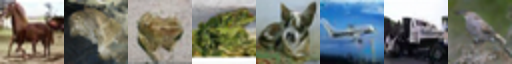

In [5]:
from diffusers import DDPMPipeline

pipe = DDPMPipeline.from_pretrained('google/ddpm-cifar10-32').to(device)
images = pipe(batch_size=8).images
make_grid(images)

In [9]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset('uoft-cs/cifar10',split='train')
print(dataset.column_names)
print(dataset[0])
image_size = 32
batch_size = 64

preprocess = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

def transform(examples):
    images = [preprocess(image.convert('RGB')) for image in examples['img']]
    return {'images':images}

dataset.set_transform(transform)


train_dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)


['img', 'label']
{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7DA07E7FD250>, 'label': 0}


X shape: torch.Size([8, 3, 32, 32])


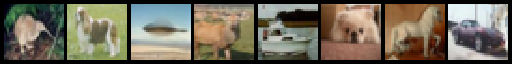

In [10]:
xb = next(iter(train_dataloader))['images'].to(device)[:8]
print("X shape:",xb.shape)
show_images(xb).resize((8*64,64),resample=Image.NEAREST)

In [11]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

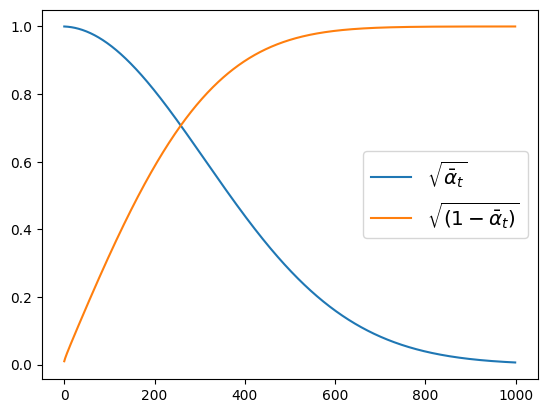

In [12]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

torch.Size([8])
torch.Size([8, 3, 32, 32])
noisy X shape  torch.Size([8, 3, 32, 32])


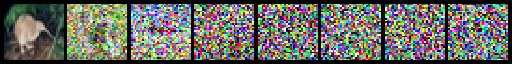

In [15]:
timesteps = torch.linspace(0,999,8).long().to(device)
print(timesteps.shape)
noise = torch.randn_like(xb)
print(noise.shape)
noisy_xb = noise_scheduler.add_noise(xb,noise,timesteps)
print("noisy X shape ",noisy_xb.shape)
show_images(noisy_xb).resize((8*64,64),resample=Image.NEAREST)

In [16]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64,128,128,256),
    down_block_types=('DownBlock2D',
                      'DownBlock2D',
                      'AttnDownBlock2D',
                      'AttnDownBlock2D'),
    up_block_types=('AttnUpBlock2D',
                    'AttnUpBlock2D',
                    'UpBlock2D',
                    'UpBlock2D')).to(device)

torch.Size([8, 3, 32, 32])


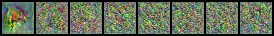

In [21]:
with torch.no_grad():
    model_prediction = model(noisy_xb,timesteps).sample
print(model_prediction.shape)
show_images(model_prediction)

In [25]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000,beta_schedule='squaredcos_cap_v2')
optimizer =  torch.optim.AdamW(model.parameters(),lr=4e-4)

losses = []

for epoch in range(30):
    for step,batch in enumerate(train_dataloader):
        clean_images = batch['images'].to(device)
        noise = torch.randn_like(clean_images).to(clean_images.device)
        bs = clean_images.shape[0]
        timesteps = torch.randint(0,noise_scheduler.num_train_timesteps,(bs,),device=clean_images.device).long()
        noisy_images = noise_scheduler.add_noise(clean_images,noise,timesteps)

        noise_pred = model(noisy_images,timesteps,return_dict=False)[0]
        loss = F.mse_loss(noise_pred,noise)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:5, loss: 0.061817789269263484
Epoch:10, loss: 0.060787388402254075
Epoch:15, loss: 0.05817115253023327
Epoch:20, loss: 0.05842800728995782
Epoch:25, loss: 0.057770591334003925
Epoch:30, loss: 0.0576332024848827


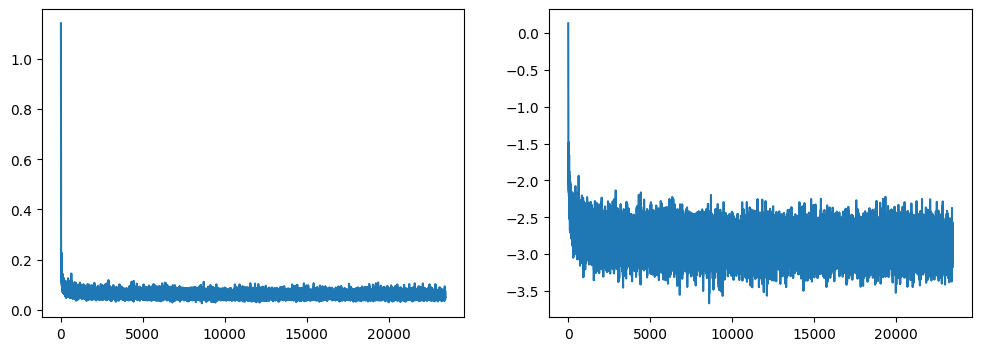

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [26]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model,scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

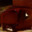

In [27]:
pipeline_output = image_pipe()
pipeline_output.images[0]

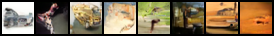

In [31]:
sample = torch.randn(8,3,32,32).to(device)

for i,t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = model(sample,t).sample

    sample = noise_scheduler.step(residual,t,sample).prev_sample

show_images(sample)

Object ` image_pipe.forward` not found.
